In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")


##### Using saas.csv or log data from API usage or store_item_sales

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df = df.drop(columns = ['Customer_Id', 'Invoice_Id'])
df.head()

,Month_Invoiced,Subscription_Type,Amount
0,2014-01-31,0.0,0.0
1,2014-01-31,2.0,10.0
2,2014-01-31,0.0,0.0
3,2014-01-31,0.0,0.0
4,2014-01-31,1.0,5.0


In [4]:
df['Subscription_Type'] = df['Subscription_Type'].astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Subscription_Type  790458 non-null  int64  
 2   Amount             790458 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 18.1+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Subscription_Type,790458.0,0.599235,0.950380,0.0,0.0,0.0,1.0,4.0
Amount,790458.0,2.996174,4.751901,0.0,0.0,0.0,5.0,20.0


In [7]:
df.isnull().sum()

Month_Invoiced       0
Subscription_Type    0
Amount               0
dtype: int64

In [8]:
#convert datetime and set index
# Reassign the sale_date column to be a datetime type
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
# Sort rows by the date and then set the index as that date
df = df.set_index('Month_Invoiced').sort_index()

In [9]:
pd.options.display.float_format = '{: .2f}'.format

df.head()

,Subscription_Type,Amount
Month_Invoiced,,
2014-01-31,0,0.00
2014-01-31,2,10.00
2014-01-31,0,0.00
2014-01-31,0,0.00
2014-01-31,1,5.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Subscription_Type  790458 non-null  int64  
 1   Amount             790458 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 18.1 MB


1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [11]:
#set train, validate, test variables 50/30/20
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

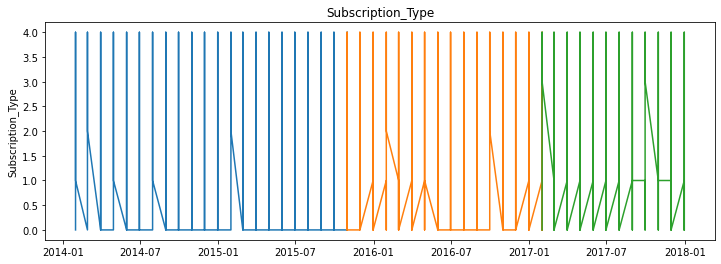

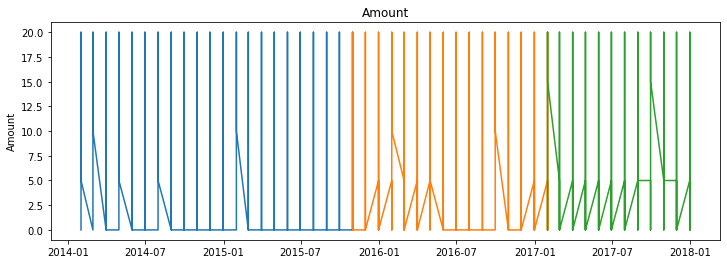

In [12]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [20]:
print(train.head(2))
print(train.shape)

                Subscription_Type  Amount
Month_Invoiced                           
2014-01-31                      0    0.00
2014-01-31                      2   10.00
(395229, 2)


In [21]:
print(validate.head(2))
print(validate.shape)

                Subscription_Type  Amount
Month_Invoiced                           
2015-10-31                      0    0.00
2015-10-31                      0    0.00
(237137, 2)


In [22]:
print(test.head(2))
print(test.shape)

                Subscription_Type  Amount
Month_Invoiced                           
2017-01-31                      0    0.00
2017-01-31                      1    5.00
(158092, 2)


2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [13]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [14]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [15]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [16]:
eval_df

,model_type,target_var,rmse


In [28]:
dollars = round(train['Amount'].mean(), 2)
items = round(train['Subscription_Type'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'Subscription_Type': [items], 'Amount': [dollars]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [29]:
yhat_df.head(2)

,Subscription_Type,Amount
Month_Invoiced,,
2015-10-31,0.50,2.48
2015-10-31,0.50,2.48


Subscription_Type -- RMSE: 1


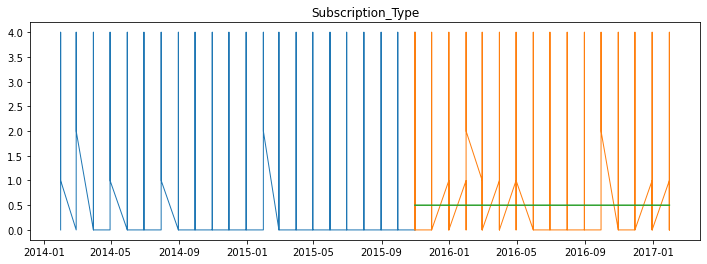

Amount -- RMSE: 5


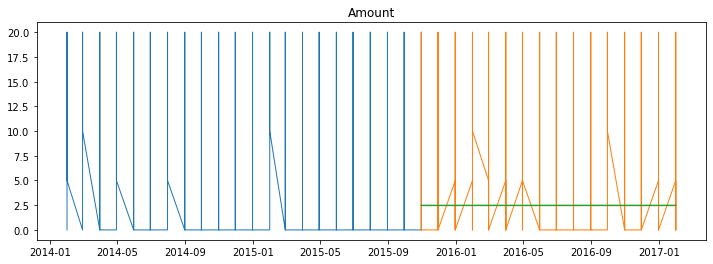

In [30]:
for col in train.columns:
    plot_and_eval(col)

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [33]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['Subscription_Type'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['Amount'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,Subscription_Type,Amount
Month_Invoiced,,
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83


Subscription_Type -- RMSE: 1


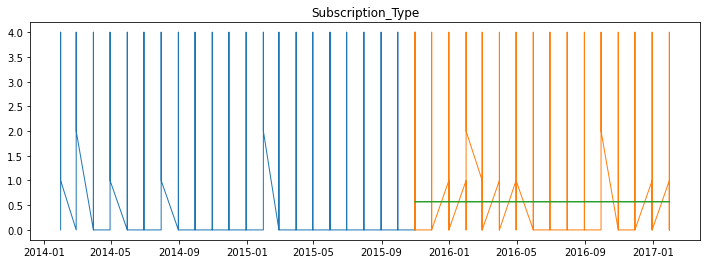

Amount -- RMSE: 5


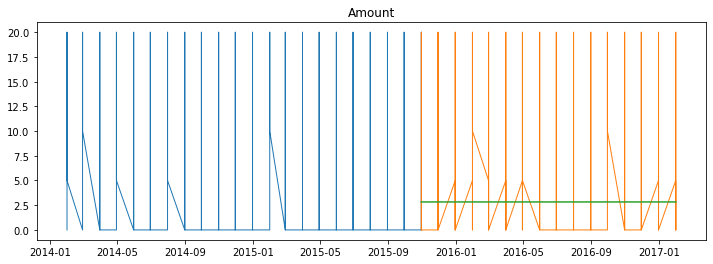

In [34]:
for col in train.columns:
    plot_and_eval(col)

In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)


In [36]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['Subscription_Type'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['Amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Subscription_Type'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Amount'
                            )

In [37]:
eval_df

,model_type,target_var,rmse
0,simple_average,Subscription_Type,1.00
1,simple_average,Amount,5.00
2,30d moving average,Subscription_Type,1.00
3,30d moving average,Amount,5.00
4,1d moving average,Subscription_Type,1.00
5,1d moving average,Amount,6.00
6,4d moving average,Subscription_Type,1.00
7,4d moving average,Amount,5.00
8,12d moving average,Subscription_Type,1.00
9,12d moving average,Amount,5.00


In [38]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
0,simple_average,Subscription_Type,1.00
1,simple_average,Amount,5.00
2,30d moving average,Subscription_Type,1.00
3,30d moving average,Amount,5.00
4,1d moving average,Subscription_Type,1.00
6,4d moving average,Subscription_Type,1.00
7,4d moving average,Amount,5.00
8,12d moving average,Subscription_Type,1.00
9,12d moving average,Amount,5.00
10,26d moving average,Subscription_Type,1.00


In [39]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

Subscription_Type 



ValueError: This function does not handle missing values

In [40]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)